<a href="https://colab.research.google.com/github/hedayet13/learning-tensorflow/blob/main/transfer_learning_in_tensorflow_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scaling up food vision mini

In [1]:
!nvidia-smi

Tue Aug 10 06:26:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#helper_functions

!wget https://raw.githubusercontent.com/hedayet13/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-08-10 06:26:09--  https://raw.githubusercontent.com/hedayet13/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-10 06:26:10 (90.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2021-08-10 06:26:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   146MB/s    in 7.9s    

2021-08-10 06:26:20 (197 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classe

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir ,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE ,
                                                                shuffle =False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [12]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.models import Sequential


data_augmentation = Sequential(
    [
     preprocessing.RandomFlip("horizontal"),
     preprocessing.RandomRotation(0.2),
     preprocessing.RandomWidth(0.2),
     preprocessing.RandomHeight(0.2),
     preprocessing.RandomZoom(0.2),
    #  preprocessing.Rescaling(1/255.)  unlike use efficientnet
    ], name = "data_augmentation"
)

In [18]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

inputs = layers.Input(shape =(224,224,3),
                      name = "input_layer")

x= data_augmentation(inputs)
x= base_model(x,training =False)
x= layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name = "output_layers")(x)
model = tf.keras.Model(inputs,outputs)

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layers (Dense)        (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [20]:
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs =5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15*len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 121s 361ms/step - loss: 3.4811 - accuracy: 0.2448 - val_loss: 2.5587 - val_accuracy: 0.4280
Epoch 2/5
237/237 [==============================] - 72s 300ms/step - loss: 2.3571 - accuracy: 0.4586 - val_loss: 2.1684 - val_accuracy: 0.4831
Epoch 3/5
237/237 [==============================] - 68s 287ms/step - loss: 1.9757 - accuracy: 0.5320 - val_loss: 2.0584 - val_accuracy: 0.4846
Epoch 4/5
237/237 [==============================] - 65s 271ms/step - loss: 1.7742 - accuracy: 0.5707 - val_loss: 1.9355 - val_accuracy: 0.4997
Epoch 5/5
237/237 [==============================] - 59s 247ms/step - loss: 1.6101 - accuracy: 0.6074 - val_loss: 1.8841 - val_accuracy: 0.5156


In [21]:
feature_extraction_results= model.evaluate(test_data)

790/790 [==============================] - 89s 112ms/step - loss: 1.7302 - accuracy: 0.5460


In [22]:
feature_extraction_results

[1.7302063703536987, 0.5460197925567627]

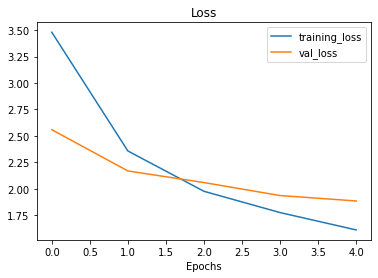

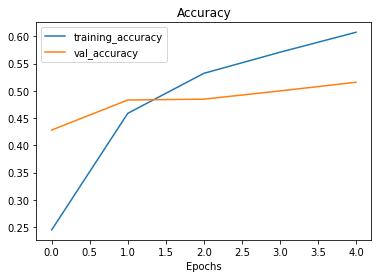

In [23]:
plot_loss_curves(history_all_classes_10_percent)

#Fine-tuning

In [24]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False 

In [25]:
model.compile(loss = "categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(lr=0.0001),
              metrics  =["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
for layer in model.layers:
  print(layer.name , layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layers True


In [27]:
for layer_number , layer in enumerate(model.layers[2].layers):
  print(layer_number,layer.name , layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [28]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data= test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch= history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 65s 243ms/step - loss: 1.3615 - accuracy: 0.6466 - val_loss: 1.8932 - val_accuracy: 0.5103
Epoch 6/10
237/237 [==============================] - 55s 229ms/step - loss: 1.2440 - accuracy: 0.6676 - val_loss: 1.9116 - val_accuracy: 0.5029
Epoch 7/10
237/237 [==============================] - 54s 226ms/step - loss: 1.1577 - accuracy: 0.6912 - val_loss: 1.9486 - val_accuracy: 0.4971
Epoch 8/10
237/237 [==============================] - 52s 216ms/step - loss: 1.0885 - accuracy: 0.7053 - val_loss: 1.8876 - val_accuracy: 0.5167
Epoch 9/10
237/237 [==============================] - 52s 219ms/step - loss: 1.0169 - accuracy: 0.7274 - val_loss: 1.8431 - val_accuracy: 0.5297
Epoch 10/10
237/237 [==============================] - 50s 209ms/step - loss: 0.9642 - accuracy: 0.7418 - val_loss: 1.9323 - val_accuracy: 0.5048


In [29]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 87s 110ms/step - loss: 1.6276 - accuracy: 0.5735


In [30]:
all_classes_10_percent_fine_tune_results

[1.627626657485962, 0.5734653472900391]

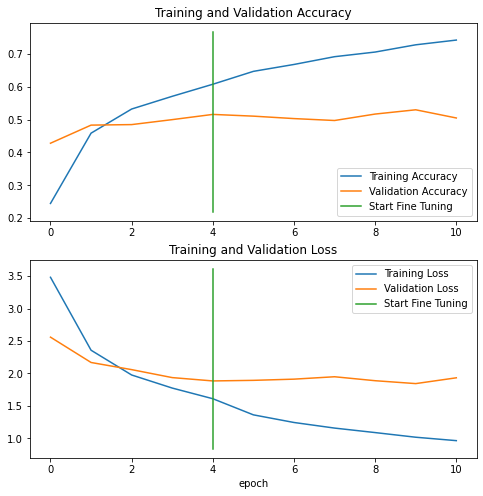

In [34]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 )

In [35]:
model.save("/content/drive/MyDrive/Tensorflow/101_food_classes_10_percent_saved_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Tensorflow/101_food_classes_10_percent_saved_model/assets


In [36]:
loaded_model  =tf.keras.models.load_model("/content/drive/MyDrive/Tensorflow/101_food_classes_10_percent_saved_model")

In [37]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 90s 113ms/step - loss: 1.6276 - accuracy: 0.5735


[1.627626657485962, 0.5734653472900391]

In [38]:
all_classes_10_percent_fine_tune_results

[1.627626657485962, 0.5734653472900391]